In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets , models , transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from scipy.io import loadmat
import scipy
from PIL import Image
from mpl_toolkits import mplot3d

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def perspective_projection(focus , center):
  proj_matrix = torch.tensor([[focus,0,center],
                              [0,focus,center],
                              [0,    0,     1]],dtype=torch.float32)
  return proj_matrix

In [ ]:
path = './drive/MyDrive/3d_Reconstruction/BFM/BFM_model_front.mat'

In [ ]:
class Basel_Face_Model():
  def __init__(self,path,focus,center,coefficients):
    super().__init__()
    model = loadmat(path)
    self.meanshape = torch.tensor(model['meanshape'].reshape(-1,1) , dtype = torch.float32) #shape of meanshape(1,3*num_of_vertices)
    self.meantex   = torch.tensor(model['meantex'],dtype = torch.float32).reshape(-1,1) #shape of meantex(1,3*num_of_vertices)
    self.id_PC     = torch.tensor(model['idBase'],dtype = torch.float32)                #shape of id_PC(3*num_of_vertices,80)
    self.tex_PC    = torch.tensor(model['texBase'],dtype = torch.float32)               #shape of tex_PC(3*num_of_vertices,80)
    self.exp_PC    = torch.tensor(model['exBase'],dtype = torch.float32)                #shape of exp_PC(3*num_of_vertices,64)
    self.skinmask  = torch.tensor(model['skinmask'] , dtype= torch.float32)             #shape of skinmask(1,num_of_vertices)
    self.landmarks = torch.sub(torch.tensor(model['keypoints'] , dtype=torch.long).reshape(-1,1) , 1) #shape of landmarks(1,68)
    self.vertex_for_faces     = torch.sub(torch.tensor(model['tri'],dtype =torch.long), 1)  #shape:(num_of_faces,3)
    self.faces_for_vertex     = torch.sub(torch.tensor(model['point_buf'],dtype = torch.long), 1 ) #shape:(number_of_vertices , 8)
    self.projection = perspective_projection(focus,center)

  def texture(self , tex_coeff):
    #shape of tex_coeff : (batch_size , 80)
    #shape of tex_PC    : (3*num_of_vertices , 80)
    #shape of meantex   : (3*num_of_vertices , 1 )
    batch_size = tex_coeff.shape[0]
    num_of_coordinates = self.tex_PC.shape[0]
    texture = torch.zeros([batch_size,num_of_coordinates])
    for i in range(batch_size):
      texture[i,:]=torch.add(self.meantex , torch.matmul(self.tex_PC,tex_coeff[i,:].reshape(-1,1))).reshape(1,-1)
    return texture.reshape(batch_size , -1 ,3) #(batch_size , num_of_vertices ,3)

  def shape(self, id_coeff , exp_coeff):
    #shape of id_coeff  : (batch_size , 80)
    #shape of exp_coeff : (batch_size , 64)
    #shape of id_PC     : (3*num_of_vertices , 80)
    #shape of exp_PC    : (3*num_of_vertices , 64)
    #shape of meanshape : (3*num_of_vertices , 1 )
    batch_size = id_coeff.shape[0]
    num_of_coordinates = self.id_PC.shape[0]
    shape = torch.zeros([batch_size,num_of_coordinates])
    for i in range(batch_size):
      shape_id = torch.matmul(self.id_PC,id_coeff[i,:].reshape(-1,1))
      shape_exp = torch.matmul(self.exp_PC , exp_coeff[i,:].reshape(-1,1))
      shape [i,:] = torch.add(self.meanshape , torch.add(shape_id,shape_exp)).reshape(1,-1)
    return shape.reshape(batch_size,-1,3) #(batch_size, num_of_vertices ,3)
  

  def rotation_translation_matrix(self , pose):
    #shape of pose = (batch_size,6)
    batch_size = pose.shape[0]
    ones = torch.ones([batch_size, 1])
    zeros = torch.zeros([batch_size, 1])
    angle_x, angle_y, angle_z = pose[:, 0:1], pose[:, 1:2], pose[:, 2:3]
    trans_x, trans_y, trans_z = pose[:, 3:4], pose[:, 4:5], pose[:, 5:6]

    rot_x = torch.cat([
            ones, zeros, zeros,
            zeros, torch.cos(angle_x), -torch.sin(angle_x), 
            zeros, torch.sin(angle_x), torch.cos(angle_x),
        ], dim=1).reshape([batch_size, 3, 3])
    rot_y = torch.cat([
            torch.cos(angle_y) , zeros , torch.sin(angle_y),
            zeros,ones,zeros,
            -torch.sin(angle_y),zeros,torch.cos(angle_y)
        ],dim=1).reshape([batch_size,3,3])
    rot_z = torch.cat([
            torch.cos(angle_z),-torch.sin(angle_z),zeros,
            torch.sin(angle_z),torch.cos(angle_z),zeros,
            zeros , zeros , ones
        ],dim=1).reshape([batch_size,3,3])
    rotation = torch.matmul(rot_z,torch.matmul(rot_y,rot_x))
    trans = torch.cat([trans_x,trans_y,trans_z],dim=1).reshape(batch_size , 3,1)
    rot_trans = torch.cat([rotation,trans],dim = 2)

    return rot_trans,rotation
  

  def transform(self, face_shape , transform_matrix):
    #shape of face_shape : (batch_size , num_of_vertices,3)
    #shape of transform_matrix :(batch_size,3,4)
    batch_size = face_shape.shape[0]
    transposed_face_shape = face_shape.permute(0,2,1) #(batch_size,3,num_of_vertices)
    transposed_face_shape_with_one  = torch.cat([transposed_face_shape,torch.ones([batch_size,1,transposed_face_shape.shape[2]])],dim=1)
    #(batch_size,4,batch_size)
    return torch.matmul(transform_matrix,transposed_face_shape_with_one) #(batch_size ,3,num_of_vertices)

  def proj_to_image(self,face_shape):
    batch_size = face_shape.shape[0]
    projected_face = torch.matmul(torch.tile(self.projection,(batch_size,1,1)),face_shape)
    #projected_face shape : [Batch_size,3,num_of_vertices]
    projected_face = projected_face[:,0:2,:] / projected_face[:,2:,:]
    #projected_face shape = [batch_size,2,num_of_vertices]
    return projected_face

  def  get_coefficients(self,coefficients):
    id_coefficient = coefficients[:,0:80]
    exp_coefficient = coefficients[:,80:144]
    tex_coefficient = coefficients[:,144:224]
    gamma           = coefficients[:,224:251]
    pose            = coefficients[:,251:257]
    return id_coefficient,exp_coefficient,tex_coefficient,gamma,pose
  
  def get_landmark(self,projected_face):
    batch_size = projected_face.shape[0]
    return projected_face.reshape(batch_size,-1,2)[:,self.landmarks]
    #shape of projected_face : (Batch_size,2,num_of_indices)
    # return shape :           (Batch_size,68,2)

  def normal(self,shape_face):
    vertex1 = shape_face[:,self.vertex_for_faces[:,0]]
    vertex2 = shape_face[:,self.vertex_for_faces[:,1]]
    vertex3 = shape_face[:,self.vertex_for_faces[:,2]]

    edge1 = vertex1-vertex2
    edge2 = vertex2-vertex3

    face_normal = torch.cross(edge1,edge2,dim=-1)
    face_normal = F.normalize(face_normal,p=2,dim=-1)
    face_normal = torch.cat([face_normal, torch.zeros(face_normal.shape[0], 1, 3)], dim=1)
    vertex_normal = torch.sum(face_normal[:, self.faces_for_vertex], dim=2)
    vertex_normal = F.normalize(vertex_normal, dim=-1, p=2)
    return vertex_normal

  def lighting(self,texture,vertex_norms,gamma):
    Batch_size= gamma.shape[0]
    num_of_vertices = texture.shape[1]
    gamma = gamma.reshape([Batch_size,9,3])
    SH_basis = torch.cat([
              (1/np.sqrt(4 * np.pi)) * torch.ones_like(vertex_norms[..., :1]),
              -((2*np.pi)/3.)*(np.sqrt(3.)/np.sqrt(4*np.pi))* vertex_norms[..., 1:2],
              ((2*np.pi)/3.)*(np.sqrt(3.)/np.sqrt(4*np.pi))* vertex_norms[..., 2:],
              -((2*np.pi)/3.)*(np.sqrt(3.)/np.sqrt(4*np.pi))* vertex_norms[..., :1],
              ((3*np.pi)/4.)*(np.sqrt(5.)/np.sqrt(12*np.pi))* vertex_norms[..., :1] * vertex_norms[..., 1:2],
              -((3*np.pi)/4.)*(np.sqrt(5.)/np.sqrt(12*np.pi))* vertex_norms[..., 1:2] * vertex_norms[..., 2:],
              (np.pi/8.)*(np.sqrt(5.)/np.sqrt(4*np.pi))* (3 * vertex_norms[..., 2:] ** 2 - 1),
              ((3*np.pi)/4.)*(np.sqrt(5.)/np.sqrt(12*np.pi))* vertex_norms[..., :1] * vertex_norms[..., 2:],
              ((3*np.pi)/8.)*(np.sqrt(5.)/np.sqrt(12*np.pi)) * (vertex_norms[..., :1] ** 2  - vertex_norms[..., 1:2] ** 2)
          ], dim=-1)
    rgb = torch.matmul(SH_basis,gamma)
    final_texture = texture*rgb
    return final_texture

In [ ]:
model = models.resnet50(pretrained = True).to(device)
for param in model.parameters():
  param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features , 512),
    nn.ReLU(),
    nn.Linear(512,257)
).to(device)

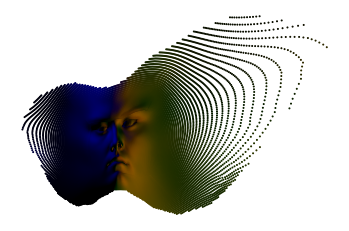

In [ ]:
transform_image = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
image = Image.open('/content/drive/MyDrive/3d_Reconstruction/face.jpg')
image = image.convert('RGB')
image = transform_image(image)
image =image.to(torch.float32)
image = torch.unsqueeze(image,0)
coefficients = model(image)
Model_3d = Basel_Face_Model(path , 1 ,-1 , coefficients)
id_coefficient,exp_coefficient,tex_coefficient,gamma,pose = Model_3d.get_coefficients(coefficients)
texture = Model_3d.texture(tex_coefficient)
shape = Model_3d.shape(id_coefficient,exp_coefficient)
rotation_translation_matrix,rotation = Model_3d.rotation_translation_matrix(pose)
transformed_face = Model_3d.transform(shape,rotation_translation_matrix)
projected_face = Model_3d.proj_to_image(transformed_face)
landmarks = Model_3d.get_landmark(projected_face)
vertex_normals = Model_3d.normal(shape)
vertex_normals = torch.matmul(rotation,vertex_normals.permute(0,2,1)).permute(0,2,1)
final_texture = Model_3d.lighting(texture,vertex_normals,gamma)
landmarks = landmarks.reshape([68,2]).permute(1,0)
projected_face = projected_face.squeeze(dim=0)
final_texture  = final_texture.squeeze(dim=0)
final_texture = (torch.nn.functional.relu(final_texture)/255.)*3
x_landmark = landmarks[0].detach().numpy()
y_landmark = landmarks[1].detach().numpy()
x = projected_face[0].detach().numpy()
y = projected_face[1].detach().numpy()
texture = final_texture.detach().numpy()
plt.rcParams["savefig.directory"]="./drive/MyDrive/3d_Reconstruction/predicted_images/"
plt.axis('off')
plt.scatter(x,y,s=1,c=texture)
plt.savefig("ProjectedFace.png")

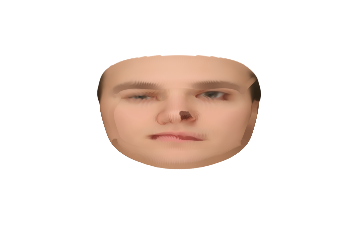

In [ ]:
model =loadmat(path)
vertices = np.array(model['meanshape'].reshape(-1,3))
texture = np.array(model['meantex']).reshape(-1,3)/255.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = [v[0] for v in vertices]
y = [v[1] for v in vertices]
z = [v[2] for v in vertices]    
ax.scatter3D(x, y, z, marker='o',c=texture)    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.grid(False)
ax.set_axis_off()
ax.view_init(90,-90)
plt.savefig("MeanFace.png")
plt.show()
